In [4]:
import torch
import os
import pandas as pd
from PIL import Image
import torchvision.transforms.functional as TF
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [5]:
data_dir = "./Particle_Size-data"

# Computing Features

- load all images in the dataset, convert to LAB, and compute the mean L value for each image.
- create a dataframe with particle_size, concentration and mean_L columns

In [6]:
df = pd.read_csv(os.path.join(data_dir, "annotations.csv"), encoding="utf-8")

mean_Ls = []

for image_path in df["image_path"]:
    image_path = os.path.join(data_dir, image_path)
    
    image = Image.open(image_path).convert("LAB")
    image = TF.to_tensor(image)
    image = image[0].mean().item()
    mean_Ls.append(image)


df['mean_L'] = mean_Ls
df['id'] = df['concentration'].astype(str) + '_' + df['particle_size'].astype(str)
df = df.drop(columns=["image_path", "iteration"])

# Cross val fold generator

- create train, val and test sets for 5 different Group folds

In [7]:
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

def get_data(df):
    gkf = GroupKFold(n_splits=5)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, test_index in gkf.split(df, groups=df['id']):
        temp_df = df.iloc[train_index]
        test_df = df.iloc[test_index]

        for train_index, val_index in gss.split(temp_df, groups=temp_df['id']):
            train_df = temp_df.iloc[train_index]
            val_df = temp_df.iloc[val_index]
    
        yield train_df, val_df, test_df


# Metrics

- some functions to compute metrics and summarize the results over many folds

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

def compute_metrics(predictions, targets):
    mae = mean_absolute_error(targets, predictions)
    rmse = root_mean_squared_error(targets, predictions)
    mse = mean_squared_error(targets, predictions)
    mape = mean_absolute_percentage_error(targets, predictions)

    r2 = r2_score(targets, predictions)
    
    return {
        "r2": r2,
        "absolute_percentage_error": mape, 
        "absolute_error": mae, "root_mse": rmse, 
        "squared_error": mse}

def summarize_metrics(metrics):
    mean = metrics.mean()
    std = metrics.std()
    mean.name = 'mean'
    std.name = 'std'
    return pd.concat([mean, std], axis=1).T
    


# Function for Cross Validation

In [9]:
def fit_model(train_df, test_df, config):
    X_train = train_df[['concentration', 'mean_L']].to_numpy()
    y_train = train_df['particle_size'].to_numpy()

    X_test = test_df[['concentration', 'mean_L']].to_numpy()
    y_test = test_df['particle_size'].to_numpy()

    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=config['degree'])),
        ('scaler', StandardScaler()),  # mainly important for high degree polynomials
        ('reg', LinearRegression())
    ])

    pipeline.fit(X_train, y_train)
    test_preds = pipeline.predict(X_test)
    test_metrics = compute_metrics(test_preds, y_test)

    return test_metrics

def fit_cross_val(df, config):
    val_metrics_all_folds = []
    test_metrics_all_folds = []

    for train_df, val_df, test_df in get_data(df):
        val_metrics = fit_model(train_df, val_df, config)
        test_metrics = fit_model(train_df, test_df, config)

        val_metrics_all_folds.append(val_metrics)
        test_metrics_all_folds.append(test_metrics)

    val_metrics_all_folds = pd.DataFrame(val_metrics_all_folds)
    test_metrics_all_folds = pd.DataFrame(test_metrics_all_folds)
    return val_metrics_all_folds, test_metrics_all_folds

def fit_final_models(df, config):
    test_metrics_all_folds = []

    for train_df, val_df, test_df in get_data(df):
        train_df = pd.concat([train_df, val_df])
        test_metrics = fit_model(train_df, test_df, config)
        test_metrics_all_folds.append(test_metrics)

    return pd.DataFrame(test_metrics_all_folds)

def full_data_predictions(df, config):
    test_predictions = []
    test_targets = []

    for train_df, val_df, test_df in get_data(df):
        train_df = pd.concat([train_df, val_df])
        X_train = train_df[['concentration', 'mean_L']].to_numpy()
        y_train = train_df['particle_size'].to_numpy()

        X_test = test_df[['concentration', 'mean_L']].to_numpy()
        y_test = test_df['particle_size'].to_numpy()

        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=config['degree'])),
            ('scaler', StandardScaler()),  # mainly important for high degree polynomials
            ('reg', LinearRegression())
        ])

        pipeline.fit(X_train, y_train)
        test_preds = pipeline.predict(X_test)

        test_predictions.extend(test_preds)
        test_targets.extend(y_test)
    
    return np.array(test_predictions), np.array(test_targets)


In [10]:
def grid_search():

    best_val_MAE = float('inf')
    best_val_config = None

    # grid search over the polynomial degree

    for degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        config = {
            'degree': degree
        }

        val_metrics, test_metrics = fit_cross_val(df, config)
        
        val_metrics = summarize_metrics(val_metrics)
        test_metrics = summarize_metrics(test_metrics)

        if val_metrics.loc['mean', 'absolute_error'] < best_val_MAE:
            best_val_MAE = val_metrics.loc['mean', 'absolute_error']
            best_val_config = config

    # refit the models but on train and validation data combined 
    # summarize over 5 folds

    best_model_test_metrics = summarize_metrics(fit_final_models(df, best_val_config))
    return best_val_config, best_model_test_metrics

In [11]:
best_config, best_test_results = grid_search()

In [12]:
best_config, best_test_results

({'degree': 4},
             r2  absolute_percentage_error  absolute_error   root_mse  \
 mean  0.869885                   0.236891       32.550526  47.799493   
 std   0.031918                   0.039511        6.669875   9.587814   
 
       squared_error  
 mean    2358.332463  
 std      943.783945  )

In [13]:
pred, gt = full_data_predictions(df, best_config)

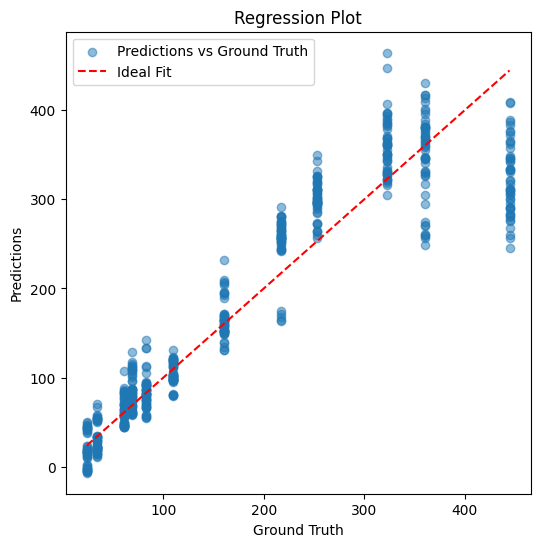

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(gt, pred, alpha=0.5, label='Predictions vs Ground Truth')
plt.plot([min(gt), max(gt)], [min(gt), max(gt)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Regression Plot')
plt.legend()
plt.show()